# Integrating Embeddings with Queries in an Information Retrieval System

## Objective

In this exercise, we will learn how to integrate embeddings with a query to enhance an Information Retrieval (IR) system. We will use both static and contextual embeddings to generate representations of queries and documents, compute their similarities, and rank the documents based on relevance to the query.

---

## Stages Covered

1. **Introduction to Pre-trained Transformer Models**
   - Load and use BERT for contextual embeddings.
   - Load and use Word2Vec for static embeddings.

2. **Generating Text Embeddings**
   - Generate embeddings for queries and documents using BERT.
   - Generate embeddings for queries and documents using Word2Vec.

3. **Computing Similarity Between Embeddings**
   - Compute cosine similarity between query and document embeddings.
   - Rank documents based on similarity scores.

4. **Integrating Embeddings with Queries**
   - Practical implementation of embedding-based retrieval for a given text corpus.

---

## Prerequisites

- TensorFlow
- Hugging Face's Transformers library
- Gensim library
- Scikit-learn library
- A text corpus in the `../data` folder

---

## Exercise

Follow the steps below to integrate embeddings with a query and enhance your IR system.



Step 0: Verify requirements:

* tensorflow
* transformers
* scikit-learn
* matplotlib
* seaborn

Step 1: Download dataset from Kaggle

URL: https://www.kaggle.com/datasets/zynicide/wine-reviews

In [1]:
import pandas as pd

# Replace 'data/winemag-data_first150k.csv' with the actual path to your downloaded CSV file
wine_df = pd.read_csv('data/winemag-data_first150k.csv')

# Now you can work with the DataFrame as usual
print(wine_df.head())
corpus = wine_df['description']


   Unnamed: 0 country                                        description  \
0           0      US  This tremendous 100% varietal wine hails from ...   
1           1   Spain  Ripe aromas of fig, blackberry and cassis are ...   
2           2      US  Mac Watson honors the memory of a wine once ma...   
3           3      US  This spent 20 months in 30% new French oak, an...   
4           4  France  This is the top wine from La Bégude, named aft...   

                            designation  points  price        province  \
0                     Martha's Vineyard      96  235.0      California   
1  Carodorum Selección Especial Reserva      96  110.0  Northern Spain   
2         Special Selected Late Harvest      96   90.0      California   
3                               Reserve      96   65.0          Oregon   
4                            La Brûlade      95   66.0        Provence   

            region_1           region_2             variety  \
0        Napa Valley               

Step 2: Load a Pre-trained Transformer Model

Use the BERT model for generating contextual embeddings and Word2Vec for static embeddings.

In [2]:
import tensorflow as tf
import gensim.downloader as api
from transformers import BertTokenizer, TFBertModel

# Load pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')


d:\U\7. Septimo\RI\ir24a\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassificatio

Step 3: Generate Text Embeddings

Static Embeddings with Word2Vec

In [3]:
import concurrent.futures
import numpy as np
import tensorflow as tf

# Función para generar los embeddings de Word2Vec
def generate_word2vec_embedding(text):
    tokens = text.lower().split()
    word_vectors = [word2vec_model[word] for word in tokens if word in word2vec_model]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Función para generar embeddings para una lista de textos
def generate_word2vec_embeddings(texts):
    embeddings = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_text = {executor.submit(generate_word2vec_embedding, text): text for text in texts}
        for future in concurrent.futures.as_completed(future_to_text):
            embeddings.append(future.result())
    return np.array(embeddings)

# Ejemplo de uso
word2vec_embeddings = generate_word2vec_embeddings(corpus[:10])
print("Word2Vec Embeddings:", word2vec_embeddings)
print("Word2Vec Shape:", word2vec_embeddings.shape)


Word2Vec Embeddings: [[ 0.03255023  0.04590465  0.00563188 ... -0.03576013  0.04962898
   0.00800393]
 [ 0.0016861  -0.00124741 -0.00065494 ... -0.04453754  0.06408358
   0.03221512]
 [ 0.01978664  0.03414721 -0.00884628 ... -0.01573336  0.06626587
  -0.02784729]
 ...
 [ 0.01875126  0.03864291  0.00552817 ... -0.07643094  0.06591528
   0.01740489]
 [ 0.03364817  0.00603784 -0.03152262 ... -0.0193573   0.12829183
  -0.00842387]
 [ 0.02863665  0.00169689 -0.00209213 ... -0.05629005  0.11204083
   0.03335422]]
Word2Vec Shape: (10, 300)


Contextual Embeddings with BERT

In [4]:
# Función para generar los embeddings de BERT
def generate_bert_embedding(text):
    # Tokenize text
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    # Generate BERT embeddings
    outputs = model(**inputs)
    # Return the first token's embedding
    return outputs.last_hidden_state[:, 0, :]

# Función para generar embeddings para una lista de textos
def generate_bert_embeddings(texts):
    embeddings = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        future_to_text = {executor.submit(generate_bert_embedding, text): text for text in texts}
        for future in concurrent.futures.as_completed(future_to_text):
            embeddings.append(future.result())
    return np.array(embeddings).transpose(0,2,1)
    #return np.array(embeddings)

# Ejemplo de uso
bert_embeddings = generate_bert_embeddings(corpus[:10])
print("BERT Embeddings:", bert_embeddings)
print("BERT Shape:", bert_embeddings.shape)


BERT Embeddings: [[[-0.4960724 ]
  [-0.5325233 ]
  [ 0.12622845]
  ...
  [-0.34278038]
  [ 0.28856477]
  [ 0.26205283]]

 [[ 0.11967503]
  [-0.48856765]
  [ 0.36453062]
  ...
  [-0.43680483]
  [ 0.1197615 ]
  [ 0.1894779 ]]

 [[-0.73173225]
  [ 0.35088515]
  [-0.01913856]
  ...
  [-0.03388363]
  [ 0.2265657 ]
  [ 0.30798066]]

 ...

 [[-0.35893524]
  [-0.58629465]
  [ 0.413421  ]
  ...
  [-0.1629948 ]
  [ 0.33213365]
  [ 0.4952076 ]]

 [[-0.05186646]
  [-0.36506537]
  [ 0.64745927]
  ...
  [-0.3147456 ]
  [ 0.05560102]
  [ 0.5154331 ]]

 [[-0.02632764]
  [-0.11705709]
  [ 0.4031698 ]
  ...
  [-0.2370885 ]
  [-0.02946982]
  [ 0.44143894]]]
BERT Shape: (10, 768, 1)


Step 4: Compute Similarity Between Embeddings

Use the scikit-learn library.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity

# Cosine similarity between Word2Vec embeddings
word2vec_embeddings = word2vec_embeddings.squeeze()
word2vec_similarity = cosine_similarity(word2vec_embeddings)
print("Word2Vec Cosine Similarity:\n", word2vec_similarity)

# Cosine similarity between BERT embeddings
bert_embeddings = bert_embeddings.squeeze()
bert_similarity = cosine_similarity(bert_embeddings)
print("BERT Cosine Similarity:\n", bert_similarity)


Word2Vec Cosine Similarity:
 [[0.99999964 0.8704564  0.8419133  0.7813313  0.7388937  0.8692663
  0.8769778  0.81447786 0.8299481  0.86583847]
 [0.8704564  1.0000004  0.8253629  0.7915441  0.70442986 0.85559994
  0.8919624  0.8199145  0.82102585 0.9090055 ]
 [0.8419133  0.8253629  1.         0.80511177 0.83916086 0.8216922
  0.83854574 0.8140328  0.84638995 0.8248522 ]
 [0.7813313  0.7915441  0.80511177 0.99999976 0.7663708  0.76002795
  0.81088406 0.82849413 0.7806283  0.7869289 ]
 [0.7388937  0.70442986 0.83916086 0.7663708  0.9999998  0.7264281
  0.7408403  0.73225087 0.84104794 0.7543802 ]
 [0.8692663  0.85559994 0.8216922  0.76002795 0.7264281  0.99999976
  0.86410356 0.7882399  0.8183166  0.87098914]
 [0.8769778  0.8919624  0.83854574 0.81088406 0.7408403  0.86410356
  1.0000001  0.8254898  0.8474779  0.9094129 ]
 [0.81447786 0.8199145  0.8140328  0.82849413 0.73225087 0.7882399
  0.8254898  1.0000002  0.77946264 0.83889055]
 [0.8299481  0.82102585 0.84638995 0.7806283  0.8410479

Step 5: Compare Contextual and Static Embeddings

Analyze and compare the similarity results from both BERT and Word2Vec embeddings.

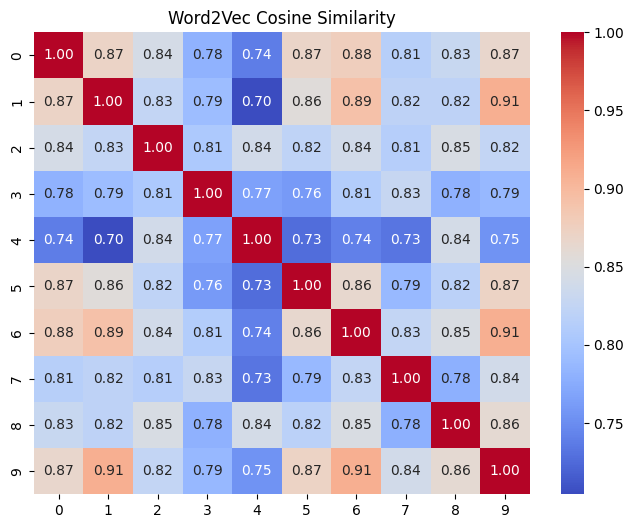

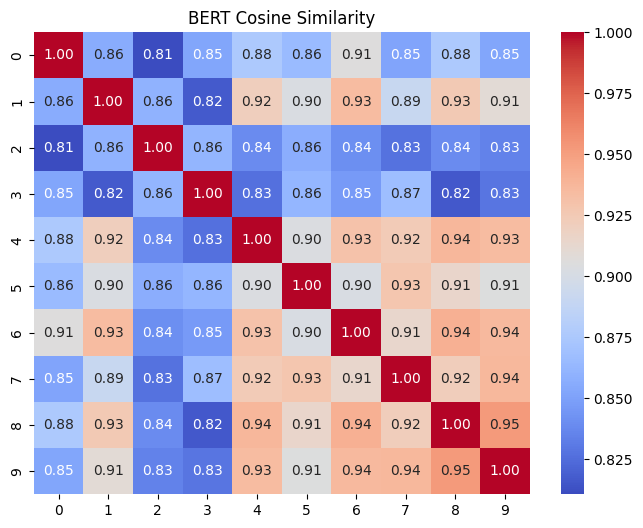

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_matrix(matrix, title, figsize=(8, 6), annotation=True):
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=annotation, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

plot_similarity_matrix(word2vec_similarity, "Word2Vec Cosine Similarity")
plot_similarity_matrix(bert_similarity, "BERT Cosine Similarity")

Step 6: Applying to Corpus

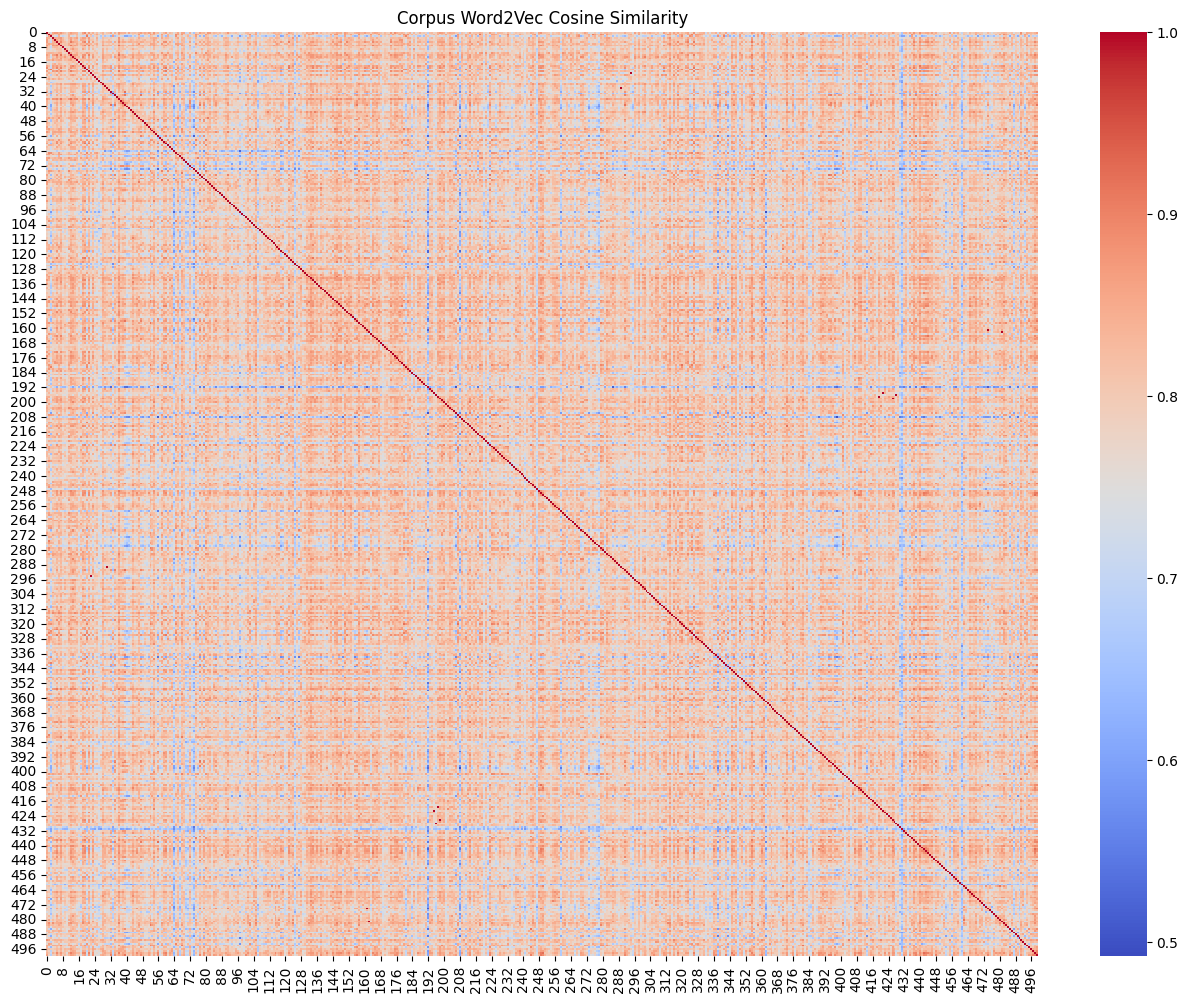

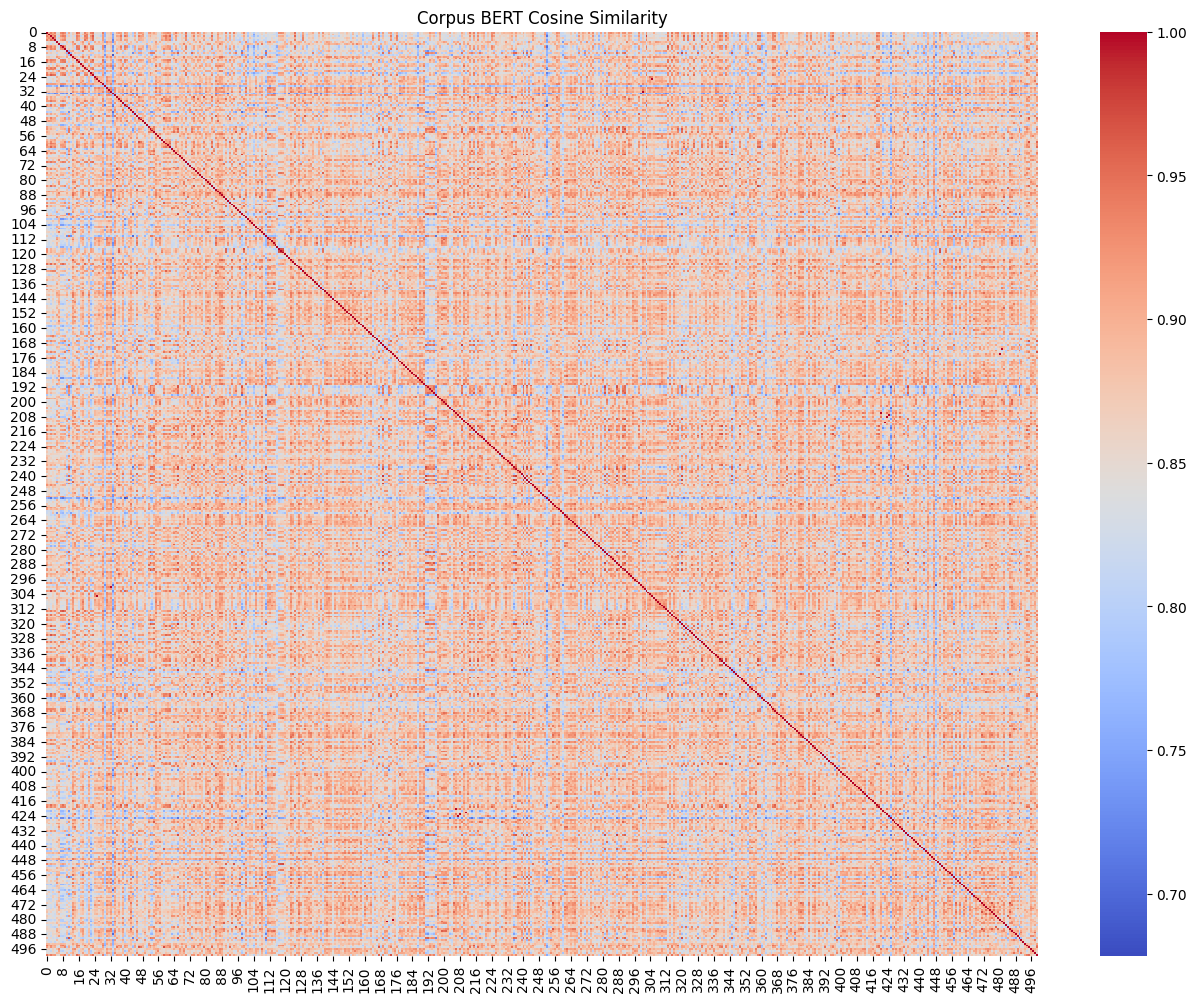

In [7]:
# Generar embeddings para el corpus
corpus_word2vec_embeddings = generate_word2vec_embeddings(corpus[:500])
corpus_bert_embeddings = generate_bert_embeddings(corpus[:500])

# Asegurarse de que los embeddings tengan la forma correcta
corpus_word2vec_embeddings = corpus_word2vec_embeddings.squeeze()
corpus_bert_embeddings = corpus_bert_embeddings.squeeze()

# Computar la similitud del coseno para el corpus
corpus_word2vec_similarity = cosine_similarity(corpus_word2vec_embeddings)
corpus_bert_similarity = cosine_similarity(corpus_bert_embeddings)

# Mostrar las matrices de similitud
plot_similarity_matrix(corpus_word2vec_similarity, "Corpus Word2Vec Cosine Similarity", figsize=(16, 12), annotation=False)
plot_similarity_matrix(corpus_bert_similarity, "Corpus BERT Cosine Similarity", figsize=(16, 12), annotation=False)


Step 7: Generate Embeddings for the Query

Generate embeddings for the query using the same model used for the documents.

In [8]:
# Definir la consulta
query = "Sample query text for information retrieval"

# Generar embeddings para la consulta usando Word2Vec
query_word2vec_embedding = generate_word2vec_embedding(query).reshape(1, -1)
print("Query Word2Vec Embedding Shape:", query_word2vec_embedding.shape)

# Generar embeddings para la consulta usando BERT
query_bert_embedding = generate_bert_embedding(query).numpy().reshape(1, -1)
print("Query BERT Embedding Shape:", query_bert_embedding.shape)


Query Word2Vec Embedding Shape: (1, 300)
Query BERT Embedding Shape: (1, 768)


Step 8: Compute Similarity Between Query and Documents

Compute the similarity between the query embedding and each document embedding.

In [9]:
# Calcular la similitud del coseno entre la consulta y los documentos (Word2Vec)
query_word2vec_similarity = cosine_similarity(query_word2vec_embedding, corpus_word2vec_embeddings)
print("Query-Document Word2Vec Cosine Similarity:", query_word2vec_similarity)

# Calcular la similitud del coseno entre la consulta y los documentos (BERT)
query_bert_similarity = cosine_similarity(query_bert_embedding, corpus_bert_embeddings)
print("Query-Document BERT Cosine Similarity:", query_bert_similarity)


Query-Document Word2Vec Cosine Similarity: [[0.27407575 0.2829286  0.30091286 0.27394575 0.2678313  0.20415857
  0.26764306 0.23920354 0.3045169  0.25348872 0.28692335 0.25799856
  0.2505888  0.26281163 0.25287688 0.30521065 0.21135077 0.32656968
  0.26901942 0.23717079 0.30292612 0.2500648  0.2713496  0.22556515
  0.2523101  0.33314762 0.25433382 0.24586108 0.2711247  0.23583624
  0.2429175  0.26956412 0.24874593 0.26692438 0.22995153 0.25780973
  0.31919512 0.24059409 0.24569046 0.21182667 0.21074232 0.21866006
  0.23402672 0.27061456 0.22515428 0.24572715 0.27835718 0.23116541
  0.26636353 0.25004965 0.24777734 0.18562245 0.281984   0.2745468
  0.3171262  0.24267848 0.18628123 0.25965643 0.25654322 0.22795913
  0.22103882 0.28748977 0.24918425 0.28072295 0.269411   0.32539752
  0.25216353 0.2973221  0.28000134 0.26066867 0.24158737 0.34452236
  0.2520902  0.29402173 0.29545945 0.28504395 0.28280208 0.19157822
  0.2918204  0.21684419 0.2624741  0.2656328  0.2359415  0.30362248
  0.26

Step 9: Retrieve and Rank Documents Based on Similarity Scores

Retrieve and rank the documents based on their similarity scores to the query.

In [10]:
# Recuperar y clasificar documentos basados en la similitud (Word2Vec)
word2vec_sorted_indices = np.argsort(-query_word2vec_similarity[0])
sorted_word2vec_docs = [corpus[i] for i in word2vec_sorted_indices]

# Recuperar y clasificar documentos basados en la similitud (BERT)
bert_sorted_indices = np.argsort(-query_bert_similarity[0])
sorted_bert_docs = [corpus[i] for i in bert_sorted_indices]

# Mostrar los documentos clasificados
print("Top documents based on Word2Vec similarity:")
for doc in sorted_word2vec_docs[:5]:
    print(doc)

print("\nTop documents based on BERT similarity:")
for doc in sorted_bert_docs[:5]:
    print(doc)


Top documents based on Word2Vec similarity:
Much like its companion from the Revelation & Sorek Bloc, this offers well-endowed flavors of melon and white peach, along with a touch of citrus. There is a sense of higher acidity, along with lower listed alcohol, rather counter-intuitive as this is the reserve. Pick either one and you'll be pleased.
This blend of Marsanne (32%), Grenache Blanc (27%), Roussanne (24%), Picpoul (14%) and Viognier starts out reduced before opening to offer pear, peach, mineral and almond. It's medium bodied in feel.
Intensely aromatic, yet big and even chunky in the mouth, this young wine remains compressed and hard-edged. Give it ample aeration, and cranberry, blackberry and black cherry fruits come alive. Dense with fruit and detailed with wet stone minerality, this should be cellared a few years, and consumed from 2020 to 2030.
Winemaker Bill Brosseau hits a single vineyard home run with this bottling from one of the Central Coast's oldest sites. It shows e